# Домашнее задание к модулю по Computer Vision

## Task 1:

У вас есть ноутбук circle_generator.ipynb Ваша задача сгенерировать изображения кружочков и натренировать нейронную сеть с архитектурой UNet на предмет сегментации кружочков на сгенерированных изображениях.
- Не забываем про разбиение на train/test/validation
- Считать значение лосса и метрики на трейне и тесте во время обучения
- Построить график лосса на трейне и тесте после обучения
- Оценить качество модели на валидации на выбранной метрике.

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

Рассмотрим подробнее, какие классы и методы предлагается использовать и допишем doc strings для лучшего понимания.

In [2]:
class BaseDataProvider(object):
    """
    Base class for providing image data and corresponding labels for training segmentation models.

    This class is designed to be subclassed. Subclasses must implement the `_next_data` method
    that returns raw image data and the corresponding labels. The class handles normalization,
    label processing, and reshaping to fit the input requirements of a segmentation network.

    Attributes:
        channels (int): Number of input data channels (default is 1 for grayscale).
        n_class (int): Number of label classes (default is 2 for binary segmentation).
        a_min (float): Minimum value for clipping during normalization (default is -inf).
        a_max (float): Maximum value for clipping during normalization (default is +inf).

    Methods:
        __call__(n): Returns n samples of processed data and labels.
        _load_data_and_label(): Loads a single pair of processed data and labels.
        _process_data(data): Normalizes the input image data.
        _process_labels(label): Converts label into one-hot encoded format.
        _post_process(data, labels): Optional hook for post-processing (e.g., data augmentation).
    """
    channels = 1
    n_class = 2

    def __init__(self, a_min=None, a_max=None):
        """
        Initializes the data provider with optional normalization limits.
    
        Args:
            a_min (float, optional): Minimum value for clipping during normalization. Defaults to -inf.
            a_max (float, optional): Maximum value for clipping during normalization. Defaults to +inf.
        """
        self.a_min = a_min if a_min is not None else -np.inf
        self.a_max = a_max if a_min is not None else np.inf

    def _load_data_and_label(self):
        """
        Loads and processes a single data-label pair.
    
        Returns:
            tuple: A tuple (train_data, labels) where:
                - train_data (np.ndarray): Normalized input data of shape (1, H, W, channels).
                - labels (np.ndarray): One-hot encoded labels of shape (1, H, W, n_class).
        """
        data, label = self._next_data()

        train_data = self._process_data(data)
        labels = self._process_labels(label)

        train_data, labels = self._post_process(train_data, labels)

        nx = train_data.shape[1]
        ny = train_data.shape[0]

        return train_data.reshape(1, ny, nx, self.channels), labels.reshape(1, ny, nx, self.n_class),

    def _process_labels(self, label):
        """
        Converts binary labels into one-hot encoded format.
    
        If n_class == 2, assumes the input is a binary mask and creates a two-channel label
        where channel 0 is the background and channel 1 is the foreground.
    
        Args:
            label (np.ndarray): A 2D array of label data (should be boolean or convertible 
            to boolean).
    
        Returns:
            np.ndarray: One-hot encoded label array of shape (H, W, n_class).
        """
        if self.n_class == 2:
            nx = label.shape[1]
            ny = label.shape[0]
            labels = np.zeros((ny, nx, self.n_class), dtype=np.float32)

            # It is the responsibility of the child class to make sure that the label
            # is a boolean array, but we a chech here just in case.
            if label.dtype != 'bool':
                label = label.astype(bool)

            labels[..., 1] = label
            labels[..., 0] = ~label
            return labels

        return label

    def _process_data(self, data):
        """
        Normalizes the input data array by clipping, taking absolute values,
        and scaling to the range [0, 1].
    
        Args:
            data (np.ndarray): Input image data.
    
        Returns:
            np.ndarray: Normalized image data.
        """
        # normalization
        data = np.clip(np.fabs(data), self.a_min, self.a_max)
        data -= np.amin(data)

        if np.amax(data) != 0:
            data /= np.amax(data)

        return data

    def _post_process(self, data, labels):
        """
        Hook for additional processing or data augmentation. 
        Meant to be overridden by subclasses.
    
        Args:
            data (np.ndarray): Normalized data array.
            labels (np.ndarray): One-hot encoded label array.
    
        Returns:
            tuple: The possibly modified (data, labels) tuple.
        """
        return data, labels

    def __call__(self, n):
        """
        Generates a batch of n processed samples.
    
        Args:
            n (int): Number of samples to generate.
    
        Returns:
            tuple: A tuple (X, Y) where:
                - X (np.ndarray): Batch of input images of shape (n, H, W, channels).
                - Y (np.ndarray): Batch of label masks of shape (n, H, W, n_class).
        """
        train_data, labels = self._load_data_and_label()
        nx = train_data.shape[1]
        ny = train_data.shape[2]

        X = np.zeros((n, nx, ny, self.channels))
        Y = np.zeros((n, nx, ny, self.n_class))

        X[0] = train_data
        Y[0] = labels
        for i in range(1, n):
            train_data, labels = self._load_data_and_label()
            X[i] = train_data
            Y[i] = labels

        return X, Y

In [3]:
class GrayScaleDataProvider(BaseDataProvider):
    """
    Data provider for synthetic grayscale images with circle (and optional rectangle) masks.

    Inherits from BaseDataProvider and implements the _next_data method to generate
    images with corresponding segmentation labels. The image and label generation
    is controlled by the create_image_and_label function.

    Attributes:
        channels (int): Number of channels in the input image (1 for grayscale).
        n_class (int): Number of output classes (2 for circles only, 3 if rectangles included).
        nx (int): Width of the image.
        ny (int): Height of the image.
        kwargs (dict): Additional keyword arguments passed to the image generator.

    Args:
        nx (int): Width of the image.
        ny (int): Height of the image.
        **kwargs: Additional parameters passed to `create_image_and_label`.
                  If 'rectangles' is True, uses 3 output classes instead of 2.
    """
    # 1 for grayscale
    channels = 1
    # 2 for circles only
    n_class = 2

    def __init__(self, nx, ny, **kwargs):
        super(GrayScaleDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3

    def _next_data(self):
        """
        Generates the next synthetic image and corresponding label mask.
    
        Returns:
            tuple:
                - data (np.ndarray): A 2D grayscale image of shape (ny, nx).
                - label (np.ndarray): A 2D label mask with values representing different classes.
        """
        return create_image_and_label(self.nx, self.ny, **self.kwargs)

In [4]:
class RgbDataProvider(BaseDataProvider):
    """
    Data provider for synthetic RGB images with circle (and optional rectangle) masks.

    Extends BaseDataProvider and overrides _next_data to return 3-channel (RGB) images.
    Uses create_image_and_label to generate synthetic grayscale data, which is then converted
    to RGB using the to_rgb function.

    Attributes:
        channels (int): Number of channels in the input image (3 for RGB).
        n_class (int): Number of output classes (2 for circles only, 3 if rectangles included).
        nx (int): Width of the image.
        ny (int): Height of the image.
        kwargs (dict): Additional keyword arguments passed to the image generator.

    Args:
        nx (int): Width of the image.
        ny (int): Height of the image.
        **kwargs: Additional parameters passed to create_image_and_label.
                  If 'rectangles' is True, sets n_class = 3.
    """
    channels = 3
    n_class = 2

    def __init__(self, nx, ny, **kwargs):
        super(RgbDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3


    def _next_data(self):
        """
        Generates the next synthetic RGB image and corresponding label mask.
    
        Returns:
            tuple:
                - data (np.ndarray): A 3-channel RGB image of shape (ny, nx, 3).
                - label (np.ndarray): A 2D label mask with class values.
        """
        data, label = create_image_and_label(self.nx, self.ny, **self.kwargs)
        return to_rgb(data), label

In [5]:
def create_image_and_label(nx,ny, cnt = 10, r_min = 5, r_max = 50, border = 92, sigma = 20, rectangles=False):
    """
    Generates a synthetic grayscale image with circular and optionally rectangular objects,
    along with corresponding segmentation masks.

    The function creates an image of size (nx, ny) with cnt random circles (and optional
    rectangles), adds Gaussian noise, and returns the image along with its label mask(s).

    Args:
        nx (int): Width of the image.
        ny (int): Height of the image.
        cnt (int): Number of shapes (circles and/or rectangles) to generate. Default is 10.
        r_min (int): Minimum radius/size of shapes. Default is 5.
        r_max (int): Maximum radius/size of shapes. Default is 50.
        border (int): Minimum distance from the border to place shapes. Default is 92.
        sigma (float): Standard deviation of Gaussian noise added to the image. Default is 20.
        rectangles (bool): Whether to include rectangles in addition to circles. Default is False.

    Returns:
        tuple:
            - image (np.ndarray): A 2D grayscale image of shape (nx, ny, 1) with values in [0, 1].
            - label (np.ndarray):
                - If rectangles is False: a binary mask of shape (nx, ny) for circles only.
                - If rectangles is True: a one-hot encoded mask of shape (nx, ny, 3), where:
                    - channel 0: background
                    - channel 1: circles
                    - channel 2: rectangles
    """

    image = np.ones((nx, ny, 1))
    label = np.zeros((nx, ny, 3), dtype=bool)
    mask = np.zeros((nx, ny), dtype=bool)
    for _ in range(cnt):
        a = np.random.randint(border, nx-border)
        b = np.random.randint(border, ny-border)
        r = np.random.randint(r_min, r_max)
        h = np.random.randint(1,255)

        y,x = np.ogrid[-a:nx-a, -b:ny-b]
        m = x*x + y*y <= r*r
        mask = np.logical_or(mask, m)

        image[m] = h

    label[mask, 1] = 1

    if rectangles:
        mask = np.zeros((nx, ny), dtype=bool)
        for _ in range(cnt//2):
            a = np.random.randint(nx)
            b = np.random.randint(ny)
            r =  np.random.randint(r_min, r_max)
            h = np.random.randint(1,255)

            m = np.zeros((nx, ny), dtype=bool)
            m[a:a+r, b:b+r] = True
            mask = np.logical_or(mask, m)
            image[m] = h

        label[mask, 2] = 1

        label[..., 0] = ~(np.logical_or(label[...,1], label[...,2]))

    image += np.random.normal(scale=sigma, size=image.shape)
    image -= np.amin(image)
    image /= np.amax(image)

    if rectangles:
        return image, label
    else:
        return image, label[..., 1]

In [6]:
def to_rgb(img):
    """
    Converts a single-channel grayscale image into an RGB visualization using a custom colormap.

    This function applies a pseudo-color mapping based on pixel intensity to enhance visualization.
    It normalizes the input, handles NaN values, and maps intensity to red, green, and blue channels.

    Args:
        img (np.ndarray): A 2D or 3D grayscale image array of shape (H, W) or (H, W, 1).

    Returns:
        np.ndarray: An RGB image of shape (H, W, 3), with values in the range [0, 1].
    """
    img = img.reshape(img.shape[0], img.shape[1])
    img[np.isnan(img)] = 0
    img -= np.amin(img)
    img /= np.amax(img)
    blue = np.clip(4*(0.75-img), 0, 1)
    red  = np.clip(4*(img-0.25), 0, 1)
    green= np.clip(44*np.fabs(img-0.5)-1., 0, 1)
    rgb = np.stack((red, green, blue), axis=2)
    return rgb

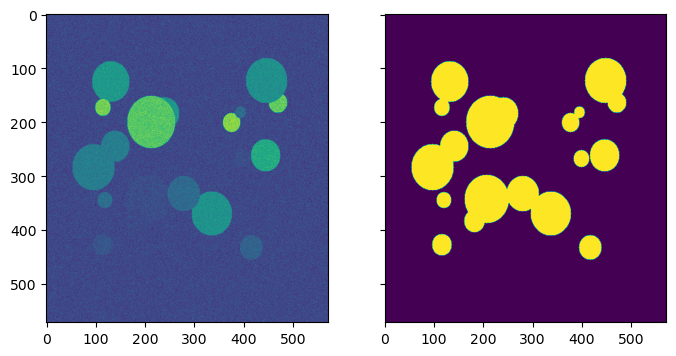

In [7]:
nx = 572
ny = 572
generator = GrayScaleDataProvider(nx, ny, cnt=20)
x_test, y_test = generator(1)

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(8, 4))
ax[0].imshow(x_test[0, ..., 0], aspect="auto")
ax[1].imshow(y_test[0, ..., 1], aspect="auto")

plt.show()

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from sklearn.metrics import jaccard_score
import random
import cv2

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Генерация кружочков:</h4>
</div>

Напишем класс для генерации датасета torch.utils.data.Dataset кружочков:

In [9]:
class CircleSegmentationDataset(Dataset):
    """
    PyTorch Dataset for generating synthetic grayscale images with circular segmentation masks.

    This dataset wraps around a data provider GrayScaleDataProvider, that generates
    synthetic data on-the-fly. Each sample returned is a tensor pair (image, mask), suitable
    for training segmentation models.

    Attributes:
        provider (BaseDataProvider): A data provider instance that generates images and masks.
        count (int): Total number of samples in the dataset.

    Args:
        provider (BaseDataProvider): Instance of a data provider GrayScaleDataProvider.
        count (int): Number of samples to be generated in the dataset.
    """
    def __init__(self, provider, count):
        self.provider = provider
        self.count = count

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
    
        Returns:
            int: The number of samples.
        """
        return self.count

    def __getitem__(self, idx):
        """
        Generates and returns a single sample from the dataset.
    
        Args:
            idx (int): Index of the sample (not used since data is generated on-the-fly).
    
        Returns:
            tuple:
                - image (torch.Tensor): Normalized grayscale image tensor of shape (1, H, W).
                - mask (torch.Tensor): Binary mask tensor of shape (H, W), corresponding to the object class.
        """
        x, y = self.provider(1)
        x = x[0].transpose(2, 0, 1)  # to (C, H, W)
        y = y[0].transpose(2, 0, 1)  # to (n_class, H, W)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y[1], dtype=torch.float32)

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> U-Net:</h4>
</div>

<b>UNet</b> — это сверточная нейросеть, специально разработанная для задач семантической сегментации, где требуется определить класс каждого пикселя изображения.
<br><b>Основные компоненты архитектуры:</b>
<br> 1.	Encoder (сжимающая часть):
 - Последовательность блоков: Conv → ReLU → Conv → ReLU → MaxPool
 - Извлекает признаки и постепенно уменьшает пространственное разрешение (H×W).
2.	Bottleneck (середина сети):
 - Самый узкий уровень, где извлекаются высокоуровневые абстрактные признаки.
3.	Decoder (восстанавливающая часть):
 - Последовательность блоков: Upsample (ConvTranspose2d) → Concatenate (skip connection) → Conv → ReLU → Conv → ReLU
 - Увеличивает размер карты признаков и восстанавливает пространственную информацию.
4.	Skip connections (прямые связи):
 - Соединяют соответствующие уровни энкодера и декодера.
 - Помогают сохранять мелкие детали, теряющиеся при понижении разрешения.
5.	Output Layer:
 - 1×1 Convolution + Sigmoid для бинарной сегментации
 - Возвращает карту вероятностей: каждый пиксель — вероятность принадлежности к классу.

Напишем класс с архитектурой U-Net для сегментации:

In [10]:
class UNet(nn.Module):
    """
    A simplified UNet architecture for binary image segmentation.

    The network follows an encoder–bottleneck–decoder structure with skip connections.
    It uses two levels of downsampling and upsampling, and outputs a single-channel
    prediction map with values in [0, 1], representing the probability of the foreground class.

    Architecture:
        - Encoder: 2 downsampling blocks (Conv + ReLU + MaxPool)
        - Bottleneck: double conv block
        - Decoder: 2 upsampling blocks with skip connections
        - Output: 1x1 convolution followed by sigmoid activation for binary segmentation

    Input shape:
        (B, 1, H, W) — grayscale image batch

    Output shape:
        (B, 1, H, W) — segmentation probability map
    """
    def __init__(self):
        super(UNet, self).__init__()
        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.ReLU(inplace=True),
            )
        self.enc1 = CBR(1, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = CBR(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.bottleneck = CBR(128, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = CBR(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = CBR(128, 64)
        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        """
        Forward pass of the UNet model.
    
        Args:
            x (torch.Tensor): Input tensor of shape (B, 1, H, W), where B is batch size.
    
        Returns:
            torch.Tensor: Output tensor of shape (B, 1, H, W) with sigmoid activation,
                          representing per-pixel probabilities for the foreground class.
        """
        # Проход через первый энкодерный блок (две свертки с ReLU активацией).
        # Вход x имеет форму (B, 1, H, W) — один канал для бинарной сегментации.
        # Выход e1 будет иметь форму (B, 64, H, W), то есть 64 канала после сверток.
        e1 = self.enc1(x)
        # Применяем максимальное объединение (MaxPool2d) с размером окна 2x2 для уменьшения пространственного разрешения (H, W).
        # Далее проходим через второй энкодерный блок, который также состоит из двух сверток с ReLU активацией.
        # В результате получаем e2 с размерностью (B, 128, H/2, W/2).
        e2 = self.enc2(self.pool1(e1))
        # Применяем еще одно объединение для сжатия данных в bottleneck блок.
        # Блок bottleneck состоит из двух сверток с ReLU активацией и позволяет извлечь более абстрактные признаки.
        # Результат b будет иметь форму (B, 256, H/4, W/4), так как pooling уменьшает разрешение на 2x.
        b = self.bottleneck(self.pool2(e2))
        # Проходим через декодерный блок 2 (dec2), который выполняет транспонированную свертку (up2).
        # Это операция апсемплинга, которая восстанавливает размерность изображения, увеличив высоту и ширину.
        # Затем выполняем конкатенацию результата апсемплинга (up2) с выходом из второго энкодера (e2) вдоль канала (dim=1).
        # Таким образом, мы используем skip-соединение, чтобы передать информацию с предыдущих слоев в декодер.
        # Результат d2 имеет форму (B, 128, H/2, W/2).
        d2 = self.dec2(torch.cat([self.up2(b), e2], dim=1))
        # Процесс аналогичен предыдущему: применяем транспонированную свертку (up1) для апсемплинга.
        # Далее выполняем конкатенацию с результатом из первого энкодера (e1), что позволяет использовать информацию из более ранних слоев.
        # Результат d1 имеет форму (B, 64, H, W), восстанавливая начальное разрешение изображения.
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        # Финальный слой — это сверточный слой с ядром 1x1, который сжимает количество каналов
        # с 64 до 1 (т.е. один канал вероятностей принадлежности к классу кружок).
        # Полученное значение — это логит (неограниченное значение), поэтому мы применяем
        # сигмоиду torch.sigmoid(), чтобы привести значения к диапазону [0, 1].
        
        # Таким образом, на выходе получаем карту вероятностей:
        # - каждый пиксель имеет значение от 0 до 1,
        # - где 0 означает уверенность в "фоне", а 1 — уверенность в "объекте".
        
        # Это необходимо при бинарной сегментации, где нужно предсказать вероятность принадлежности
        # каждого пикселя к одному классу ("кружок" или "не кружок").
        return torch.sigmoid(self.final(d1))

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Data Preparation</h4>
</div>

Подготовка синтетического датасета для сегментации:

In [11]:
# Размеры создаваемого изображения (ширина и высота)
nx = 572
ny = 572

# Создаем провайдер данных, который генерирует изображения с 20 случайными кругами
provider = GrayScaleDataProvider(nx, ny, cnt=20)
# Создаем PyTorch Dataset, который будет предоставлять 100 сгенерированных изображений и масок
dataset = CircleSegmentationDataset(provider, count=100)

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Разбиение датасета</h4>
</div>

In [12]:
# Размер обучающей выборки — 60% 
train_size = int(0.6 * len(dataset))
# Размер валидационной выборки — 20% 
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

Сделаем три независимые подвыборки: для обучения, валидации и тестирования

In [13]:
batch_size = 5
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Model Training</h4>
</div>

Подготовка модели к обучению:

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
# Функция потерь — бинарная кросс-энтропия.
criterion = nn.BCELoss()
# Оптимизатор — Adam
optimizer = optim.Adam(model.parameters(), lr=0.001)

<br>Модель обучается в течение epochs с отслеживанием функции потерь на:
 - Обучающей выборке (Train Loss)
 - Валидационной выборке (Val Loss)
   
<br>Каждая эпоха включает:
 - Прямой и обратный проход по батчам
 - Обновление весов с помощью оптимизатора Adam
 - Подсчет средней ошибки на обучении и тесте

In [15]:
# Списки для сохранения значений функции потерь
train_losses, val_losses = [], []
# Количество эпох 
epochs = 10

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        # Обнуляем градиенты перед обратным проходом
        optimizer.zero_grad()
        # Прямой проход — получаем предсказания от модели
        out = model(x)
        # Вычисляем функцию потерь
        loss = criterion(out, y.unsqueeze(1))
        # Обратное распространение ошибки (backpropagation)
        loss.backward()
        # Обновляем параметры модели с помощью градиентного спуска (Adam)
        optimizer.step()
        # Сохраняем значение потерь для этой итерации
        total_train_loss += loss.item()
    # Средняя ошибка за всю обучающую эпоху
    train_losses.append(total_train_loss / len(train_loader))

    model.eval()
    #Valid loss
    total_test_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            # Предсказания от модели
            out = model(x)
            # Вычисляем функцию потерь
            loss = criterion(out, y.unsqueeze(1))
            total_test_loss += loss.item()
    # Средняя ошибка на тесте за текущую эпоху
    val_losses.append(total_test_loss / len(val_loader))
    
    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}")

Epoch 1/10 - Train Loss: 0.5017, Val Loss: 0.2685
Epoch 2/10 - Train Loss: 0.2080, Val Loss: 0.1426
Epoch 3/10 - Train Loss: 0.0895, Val Loss: 0.1605
Epoch 4/10 - Train Loss: 0.1312, Val Loss: 0.1222
Epoch 5/10 - Train Loss: 0.0796, Val Loss: 0.0718
Epoch 6/10 - Train Loss: 0.0759, Val Loss: 0.0498
Epoch 7/10 - Train Loss: 0.0623, Val Loss: 0.1672
Epoch 8/10 - Train Loss: 0.0650, Val Loss: 0.0501
Epoch 9/10 - Train Loss: 0.0902, Val Loss: 0.0584
Epoch 10/10 - Train Loss: 0.0820, Val Loss: 0.0788


<b>Выводы:</b>
<br>Модель обучается уверенно — быстрая сходимость и устойчивое поведение. Переобучения нет — нет резкого роста валидационной/тестовой ошибки при снижении тренировочной.

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;"> Loss Plot</h4>
</div>

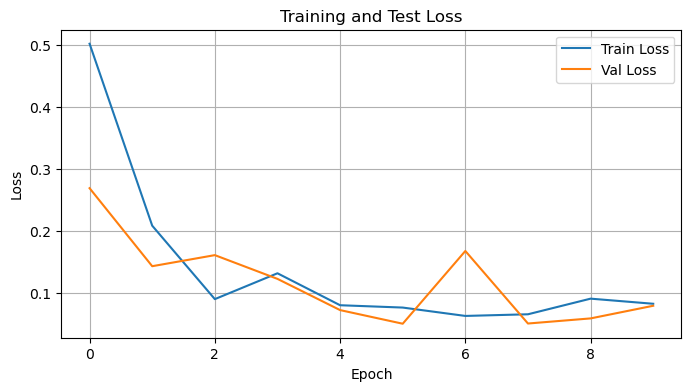

In [16]:
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')  
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss")
plt.legend()
plt.grid(True)
plt.show()

<b>Выводы:</b>
<br>Потери на обучающей и тестовой выборках стремительно падают на первых эпохах — это признак того, что модель быстро обучается. Test Loss не начинает расти после снижения — модель не переобучилась.

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;">
IoU Evaluation on Validation</h4>
</div>

Оценка качества сегментации: IoU
<br>IoU измеряет степень совпадения предсказанной и истинной масок:
 - Для каждого изображения считается индивидуальный IoU, затем берётся среднее значение.
 - $\text{IoU} = \frac{\text{Intersection}}{\text{Union}}$

In [17]:
# Список для хранения значений IoU (Intersection over Union) для каждого изображения
ious = []
# Отключаем вычисление градиентов 
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        # Получаем предсказание от модели 
        out = model(x)
        # Превращаем вероятности в бинарные маски
        pred = (out > 0.5).float()
        for p, t in zip(pred, y.unsqueeze(1)):
            # Перебираем отдельные изображения в батче
            # Вычисляем IoU
            iou = jaccard_score(t.cpu().numpy().flatten(), p.cpu().numpy().flatten())
            ious.append(iou)
# Вычисляем среднее значение IoU
print(f"Mean IoU on validation set: {np.mean(ious):.4f}")

Mean IoU on validation set: 0.8867


<b>Выводы:</b>
<br>IoU > 0.8 означает, что модель хорошо научилась отделять кружочки от фона.

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;">Визуализация примеров изображений из val_loader:</h4>
</div>

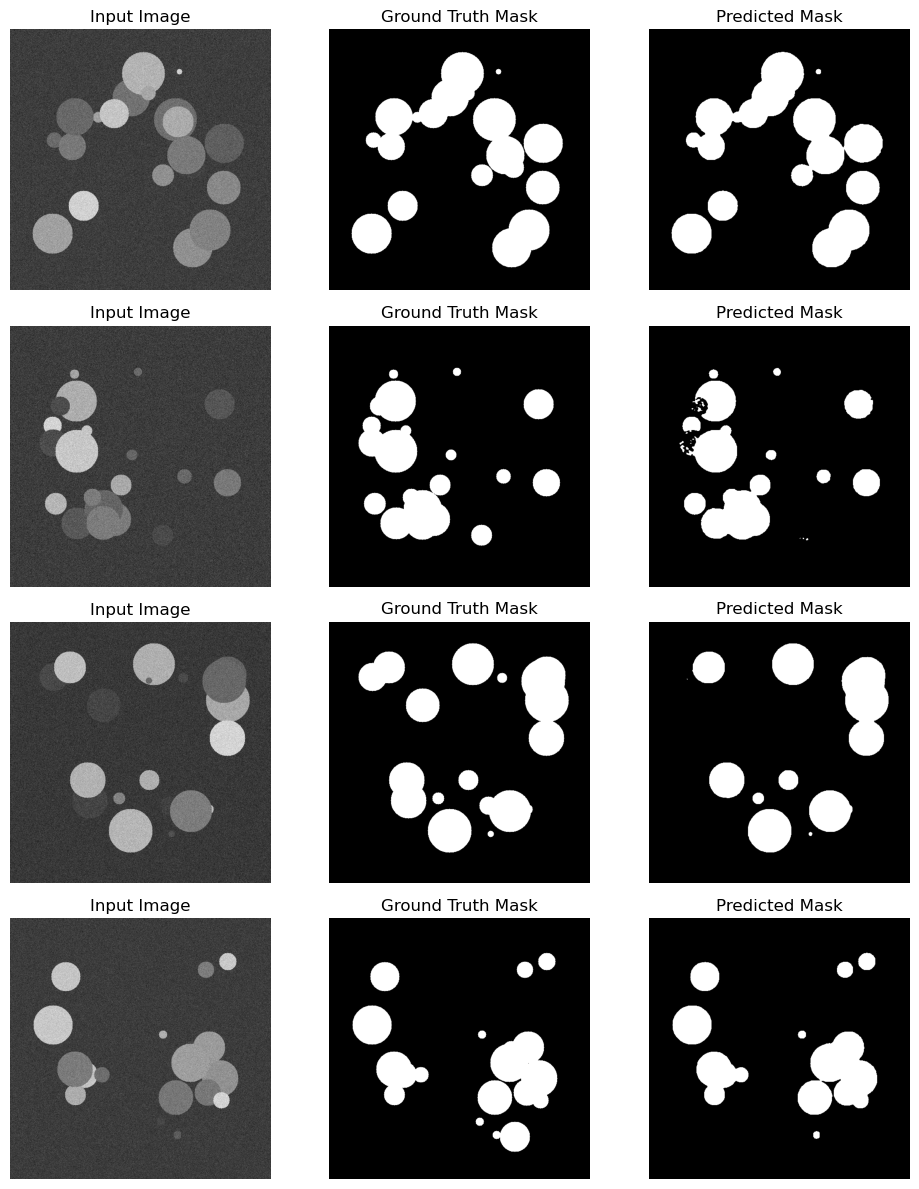

In [18]:
example_batch = next(iter(val_loader))
images, true_masks = example_batch
images, true_masks = images.to(device), true_masks.to(device)

with torch.no_grad():
    predicted_masks = model(images)
    predicted_masks = (predicted_masks > 0.5).float()

# Визуализация нескольких примеров
num_samples = min(4, images.shape[0])
fig, axs = plt.subplots(num_samples, 3, figsize=(10, 3 * num_samples))

for i in range(num_samples):
    axs[i, 0].imshow(images[i][0].cpu(), cmap='gray')
    axs[i, 0].set_title("Input Image")
    axs[i, 1].imshow(true_masks[i].cpu(), cmap='gray')
    axs[i, 1].set_title("Ground Truth Mask")
    axs[i, 2].imshow(predicted_masks[i][0].cpu(), cmap='gray')
    axs[i, 2].set_title("Predicted Mask")
    for j in range(3):
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

<b>Выводы:</b>
<br>Модель UNet успешно обучилась на синтетических изображениях — достигнута хорошая сходимость без переобучения

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;">Метрики на test_loader:</h4>
</div>

In [19]:
from sklearn.metrics import jaccard_score, f1_score, accuracy_score, precision_score, recall_score

In [20]:
ious = []
dices = []
accuracies = []
precisions = []
recalls = []
f1s = []

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        pred = (out > 0.5).float()

        for p, t in zip(pred, y.unsqueeze(1)):
            y_true = t.cpu().numpy().flatten()
            y_pred = p.cpu().numpy().flatten()
        
            ious.append(jaccard_score(y_true, y_pred))
            dices.append(2 * np.logical_and(y_true, y_pred).sum() / (y_true.sum() + y_pred.sum() + 1e-8))
            accuracies.append(accuracy_score(y_true, y_pred))
            precisions.append(precision_score(y_true, y_pred))
            recalls.append(recall_score(y_true, y_pred))
            f1s.append(f1_score(y_true, y_pred))

# 📊 Вывод средних значений по всем изображениям
print("Test metrics:")
print(f"Mean IoU:       {np.mean(ious):.4f}")
print(f"Mean Dice:      {np.mean(dices):.4f}")
print(f"Accuracy:       {np.mean(accuracies):.4f}")
print(f"Precision:      {np.mean(precisions):.4f}")
print(f"Recall:         {np.mean(recalls):.4f}")
print(f"F1 Score:       {np.mean(f1s):.4f}")

Test metrics:
Mean IoU:       0.8647
Mean Dice:      0.9253
Accuracy:       0.9781
Precision:      0.9953
Recall:         0.8684
F1 Score:       0.9253


<b>Выводы</b>:
 - Высокий IoU и Dice говорят о точном совпадении форм и границ объектов.
 - Accuracy 98%, но лучше трактовать осторожно, так как фон занимает большую часть изображения.
 - Recall и Precision - модель находит большинство кружочков и почти не ошибается.
 - F1 Score  - модель сегментирует уверенно.
<br>Модель UNet очень хорошо обучилась и хорошо показала себя на тестовых данных.

<div style="background-color: lightblue; padding: 10px; border-radius: 10px;">
    <h4 style="color: darkblue;">Изображения из test_loader:</h4>
</div>

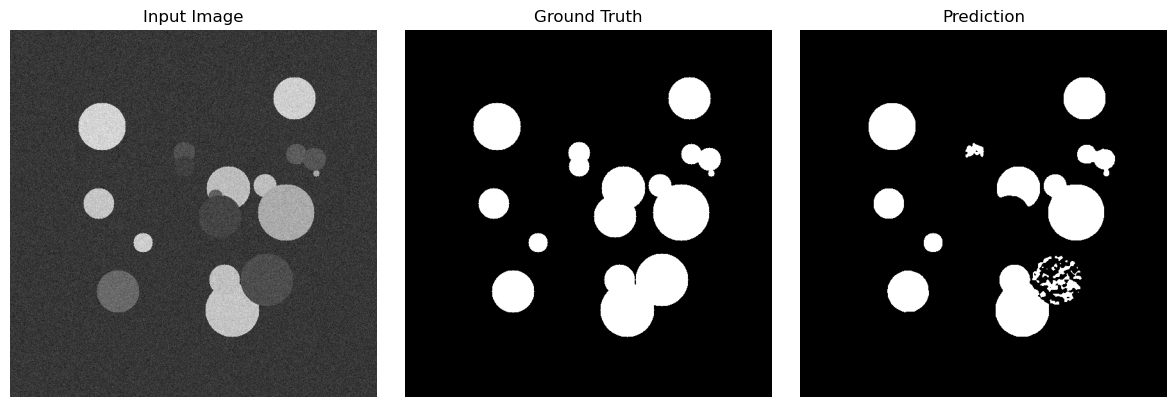

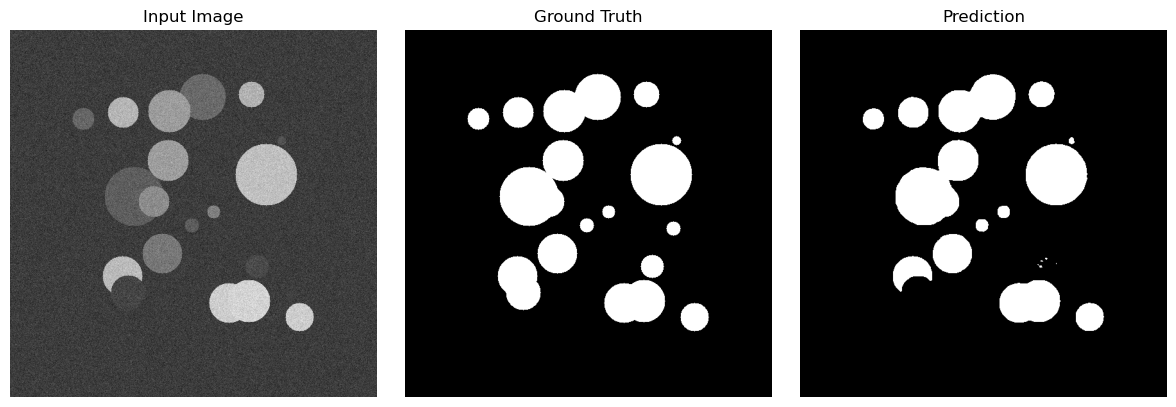

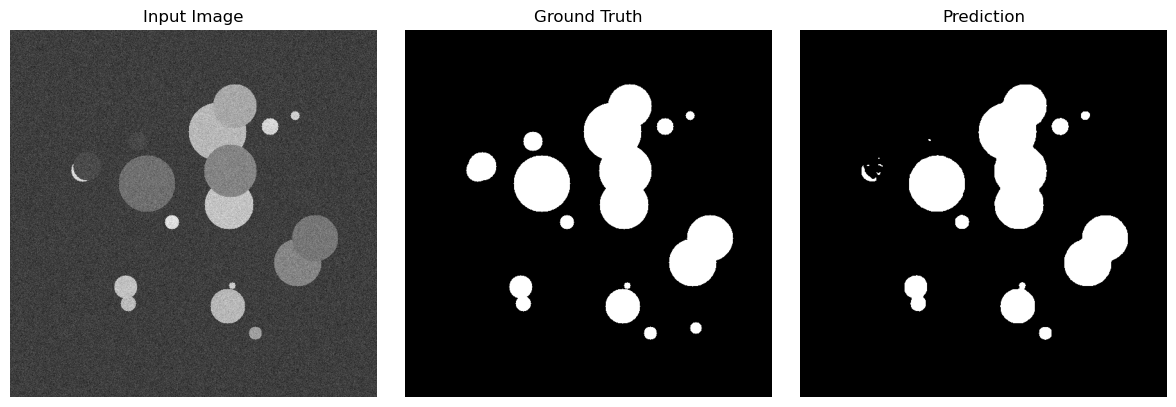

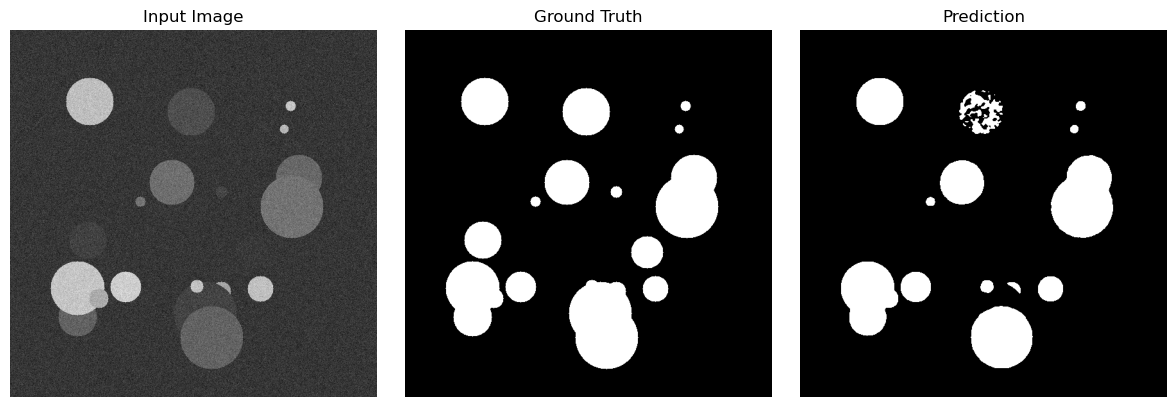

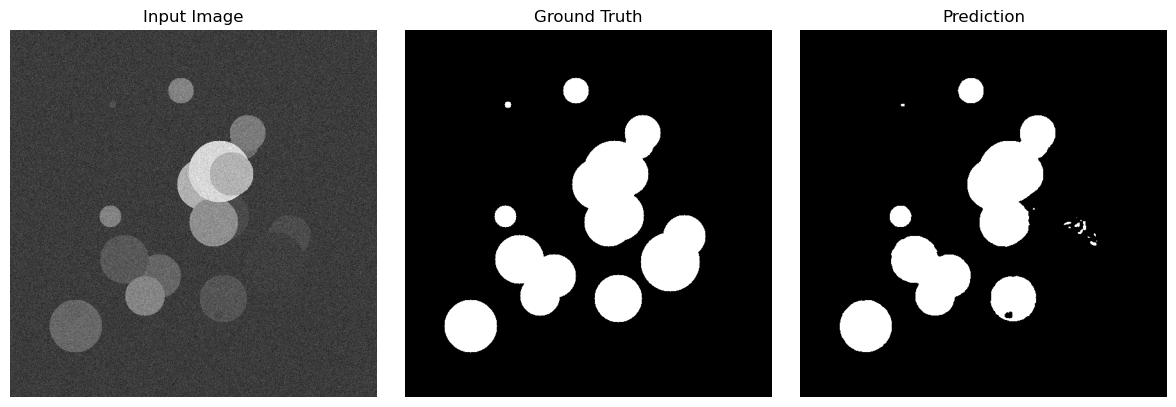

In [21]:
n = 5  
examples = 0

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        pred = (out > 0.5).float()

        for i in range(x.size(0)):
            img = x[i, 0].cpu().numpy()                    # (H, W), канал изображения
            true_mask = y[i].cpu().numpy()                # (H, W), ground truth маска
            pred_mask = pred[i, 0].cpu().numpy()          # (H, W), predicted маска

            # Отображаем
            plt.figure(figsize=(12, 4))
            
            plt.subplot(1, 3, 1)
            plt.imshow(img, cmap='gray')
            plt.title("Input Image")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(true_mask, cmap='gray')
            plt.title("Ground Truth")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(pred_mask, cmap='gray')
            plt.title("Prediction")
            plt.axis("off")

            plt.tight_layout()
            plt.show()

            examples += 1
            if examples >= n:
                break
        if examples >= n:
            break